In [1]:
import benchmark
from complex import ComplexSIMD, ComplexFloat64
from math import iota
from python import Python
from runtime.llcl import num_cores
from algorithm import parallelize, vectorize
from tensor import Tensor
from utils.index import Index

alias float_type = DType.float64
alias simd_width = 2 * simdwidthof[float_type]()

In [2]:
alias width = 960
alias height = 960
alias MAX_ITERS = 200

alias min_x = -2.0
alias max_x = 0.6
alias min_y = -1.5
alias max_y = 1.5

In [3]:
# Compute the number of steps to escape.
def mandelbrot_kernel(c: ComplexFloat64) -> Int:
    z = c
    for i in range(MAX_ITERS):
        z = z * z + c
        if z.squared_norm() > 4:
            return i
    return MAX_ITERS


def compute_mandelbrot() -> Tensor[float_type]:
    # create a matrix. Each element of the matrix corresponds to a pixel
    t = Tensor[float_type](height, width)

    dx = (max_x - min_x) / width
    dy = (max_y - min_y) / height

    y = min_y
    for row in range(height):
        x = min_x
        for col in range(width):
            t[Index(row, col)] = mandelbrot_kernel(ComplexFloat64(x, y))
            x += dx
        y += dy
    return t

In [4]:
%%python
from importlib.util import find_spec
import shutil
import subprocess

fix = """
-------------------------------------------------------------------------
fix following the steps here:
    https://github.com/modularml/mojo/issues/1085#issuecomment-1771403719
-------------------------------------------------------------------------
"""

def install_if_missing(name: str):
    if find_spec(name):
        return

    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path" + fix)
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found" + fix)

install_if_missing("numpy")
install_if_missing("matplotlib")

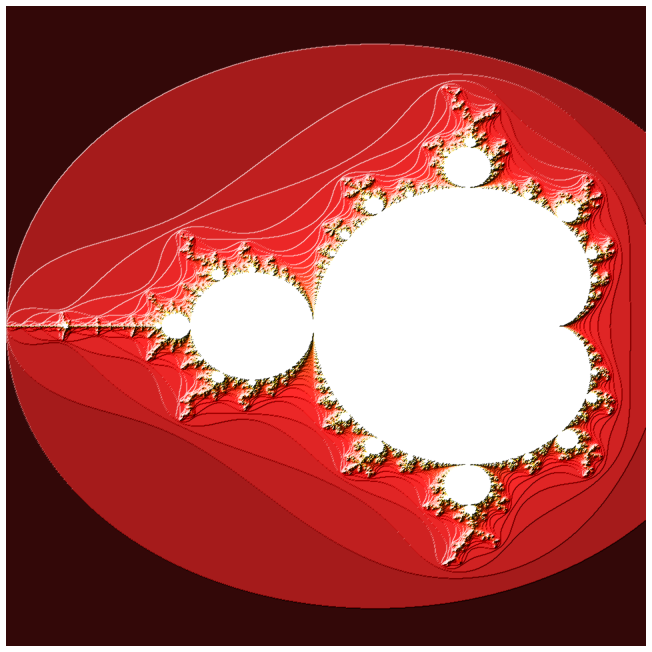

In [5]:
def show_plot(tensor: Tensor[float_type]):
    alias scale = 10
    alias dpi = 64

    np = Python.import_module("numpy")
    plt = Python.import_module("matplotlib.pyplot")
    colors = Python.import_module("matplotlib.colors")

    numpy_array = np.zeros((height, width), np.float64)

    for row in range(height):
        for col in range(width):
            numpy_array.itemset((col, row), tensor[col, row])

    fig = plt.figure(1, [scale, scale * height // width], dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)
    light = colors.LightSource(315, 10, 0, 1, 1, 0)

    image = light.shade(numpy_array, plt.cm.hot, colors.PowerNorm(0.3), "hsv", 0, 0, 1.5)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

show_plot(compute_mandelbrot())